In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt


In [3]:

url = 'https://raw.githubusercontent.com/PacktPublishing/TensorFlow-Developer-Certificate-Guide/main/Chapter%2012/sales_data.csv'
df = pd.read_csv(url)

In [4]:
sales = df['Sales'].values
split = int(0.8 * len(sales))
train_data = sales[:split]
val_data= sales[split:]


In [5]:
#converts the data column into a datetime format
df['Date'] = pd.to_datetime(df['Date'])
#change the date column by setting it as the index of our DataFrame
df.set_index('Date', inplace=True)

In [6]:
window_size = 30
batch_size=64
buffer_size=1000


In [7]:
def window_dataset(series, window_size, batch_size, buffer_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.map(lambda window:(window[:-1], window[-1]))
  dataset = dataset.shuffle(buffer_size)
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [8]:
def create_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(128, input_shape=[window_size], activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])
  return model

In [9]:
def compile_fit_model(learning_rate_schedule):
  compiled_model = create_model()
  loss = tf.keras.losses.mean_squared_error
  optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)
  compiled_model.compile(loss=loss,
                optimizer=optimizer)
  train_dataset = window_dataset(train_data, window_size, batch_size, buffer_size)
  compiled_model.fit(train_dataset,
            epochs=100,
            verbose=1)
  return compiled_model


In [10]:
def predict_model(model, series, window_size, batch_size, buffer_size):
  val_dataset = tf.data.Dataset.from_tensor_slices(series)
  val_dataset = val_dataset.window(window_size, shift=1, drop_remainder=True)
  val_dataset = val_dataset.flat_map(lambda w:w.batch(window_size))
  val_dataset = val_dataset.batch(batch_size).prefetch(1)
  forecast = model.predict(val_dataset)
  return forecast


In [11]:
def predicted_data(model):
  forecast_series = sales[split-window_size:-1]
  predictions = predict_model(model, forecast_series, window_size, batch_size, buffer_size)
  results = predictions.squeeze().squeeze()
  return results

In [12]:
lr_schedules ={
    'Exponential Decay' : tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01,
        decay_steps=100,
        decay_rate=0.96
    ),
    'Piecewise constant': tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        [30,60],
        [0.1,0.01,0.001]
    ),
    'Polynomial decay': tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=0.1,
        decay_steps=100,
        end_learning_rate=0.01,
        power=1.0
    )
}

In [22]:
def plot_series(forecast,val, startDate=None, endDate=None, title='Model plot' ):
   plt.figure(figsize=(5,3))
   plt.plot(forecast, 'b', label="Forecast")
   plt.plot(val,'r', label="Actual validation")
   plt.title(title)
   plt.legend()
   plt.show()


In [18]:
predictions = {}
for key, value in lr_schedules.items():
  compiled_fited_mode = compile_fit_model(value)
  result= predicted_data(compiled_fited_mode)
  predictions[key] = result

Epoch 1/100
46/46 [==============================] - 1s 9ms/step - loss: 909.3688
Epoch 2/100
46/46 [==============================] - 0s 7ms/step - loss: 57.2888
Epoch 3/100
46/46 [==============================] - 0s 8ms/step - loss: 58.0994
Epoch 4/100
46/46 [==============================] - 0s 7ms/step - loss: 53.3814
Epoch 5/100
46/46 [==============================] - 0s 8ms/step - loss: 49.4712
Epoch 6/100
46/46 [==============================] - 0s 8ms/step - loss: 46.9121
Epoch 7/100
46/46 [==============================] - 1s 8ms/step - loss: 44.2608
Epoch 8/100
46/46 [==============================] - 0s 8ms/step - loss: 46.5665
Epoch 9/100
46/46 [==============================] - 0s 7ms/step - loss: 40.6500
Epoch 10/100
46/46 [==============================] - 0s 7ms/step - loss: 42.7319
Epoch 11/100
46/46 [==============================] - 0s 8ms/step - loss: 39.2977
Epoch 12/100
46/46 [==============================] - 0s 7ms/step - loss: 40.9105
Epoch 13/100
46/46 [====

In [30]:
def evaluate_model(prediction, validation):
  mae = tf.keras.metrics.mean_absolute_error(prediction, validation).numpy()
  mse = tf.keras.metrics.mean_squared_error(prediction, validation).numpy()
  return (mae, mse)

Exponential Decay


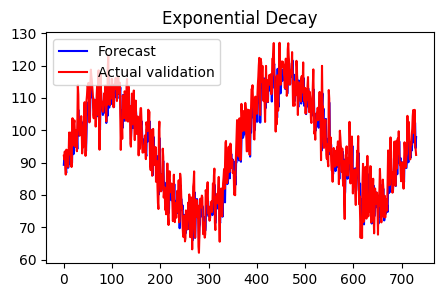

Piecewise constant


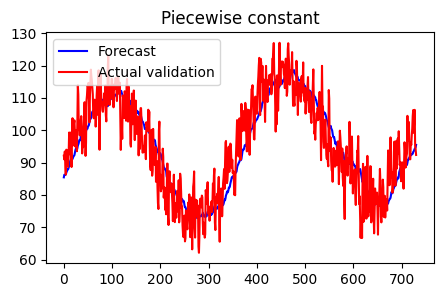

Polynomial decay


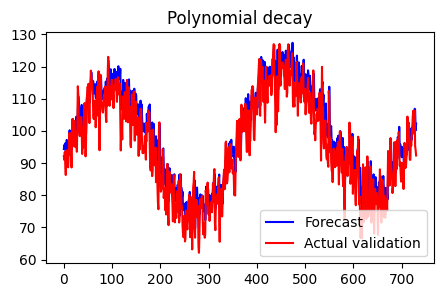

,Learning rate shedule,mae,mse
0,Exponential Decay,4.291378,28.846005
1,Piecewise constant,5.667594,49.797113
2,Polynomial decay,5.140868,40.346827


In [31]:
maes=[]
mses=[]
lrs_name=[]
for key, value in predictions.items():
  print(key)
  plot_series(value, val_data,title=key)
  mae, mse=evaluate_model(value, val_data)
  maes.append(mae)
  mses.append(mse)
  lrs_name.append(key)

results = pd.DataFrame({'Learning rate shedule': lrs_name,
                       'mae': maes,
                       'mse':mses})
results

